# Base Modifier Deck Analysis
This is a breakdown of the damage probabilities for the base modifier deck using pands, matplotlib, and dask to simulate the deck and collect relevant statistics.

In [1]:
import random
import pandas as pd  
import matplotlib.pyplot as plt
from itertools import chain
from gloomhaven.deck import GloomhavenDeck
from gloomhaven.render import render_tables, format_table_to_hmtl

In [2]:
deck = GloomhavenDeck()

In [3]:
attack_data = {}
base_attacks = [1, 2, 3, 4, 5]
samp_size = 100_000

def attacks(samp_size, attack):
    for _ in range(samp_size):
        targs = random.choices(population=[1, 2, 3], weights=[0.6, 0.3, 0.1], k=1)[0]
        yield [attack] * targs

attack_data = {}
for val in base_attacks:
    moves = deck.simulate(attacks(samp_size, val))
    moves = list(chain(*moves))[:samp_size]
    attack_data[f"base_attack_{val}"] = [dmg for dmg, _ in moves]

attack_data = pd.DataFrame(attack_data)

In [4]:
def get_counts(srs: pd.Series):
    srs = srs.value_counts()
    for attack_val in range(srs.index.max()+1):
        if attack_val not in srs.index:
            srs[attack_val] = 0
    srs = srs / samp_size
    srs.sort_index()
    return srs

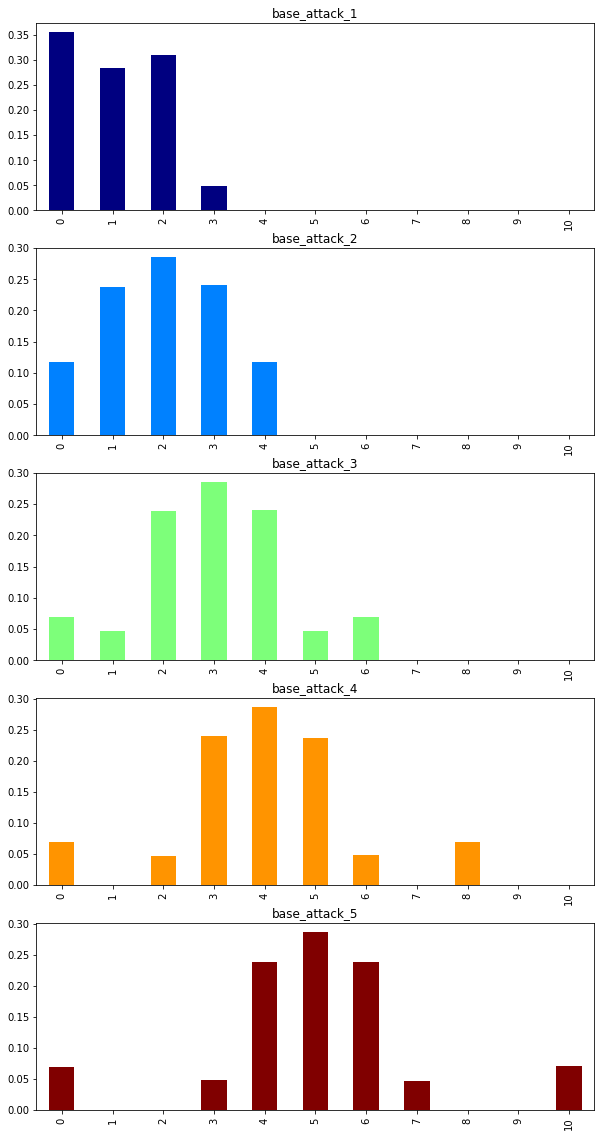

In [5]:
_ = attack_data.apply(get_counts, axis=0) \
    .plot(
        kind="bar",
        subplots=True, 
        figsize=(10,20),
        legend=False,
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max(base_attacks)*2+1)],
    )
plt.savefig("../assets/base_deck.jpg")

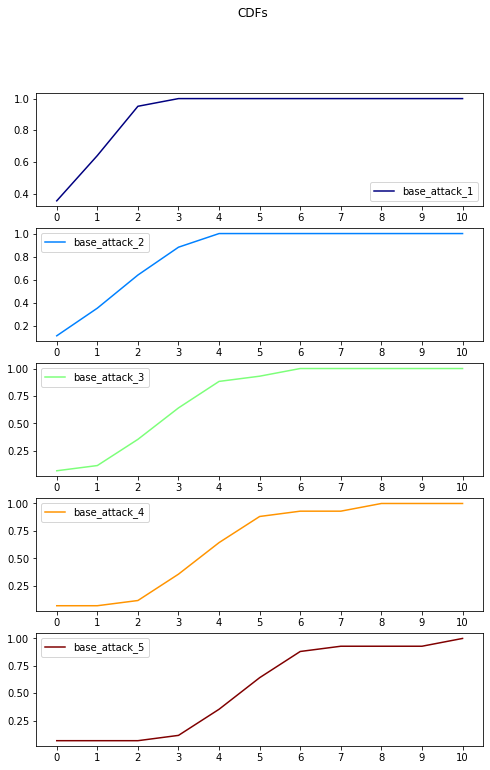

In [10]:
_ = attack_data.apply(get_counts, axis=0) \
    .fillna(0) \
    .cumsum() \
    .plot(
        kind="line",
        subplots=True, 
        figsize=(8, 12),
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max(base_attacks)*2+1)],
        title="CDFs"
    )

tmp = attack_data.apply(lambda x: x.value_counts(normalize=True), axis=0)
missing = [i for i in range(max(tmp.index)) if i not in tmp.index]
for i in missing:
    tmp.loc[i, :] = None
tmp = tmp.fillna(0).cumsum()
tmp.sort_index(axis=0, inplace=True)
tmp_table = format_table_to_hmtl(tmp)

with open("../assets/base_deck_cdfs.html", "w") as f:
    f.write(render_tables([("CDFs", tmp_table)]))

In [13]:
# survival function table
1 - tmp.round(3)

,base_attack_1,base_attack_2,base_attack_3,base_attack_4,base_attack_5
0,0.644,0.882,0.930,0.931,0.931
1,0.359,0.644,0.883,0.931,0.931
2,0.048,0.358,0.644,0.883,0.931
3,0.000,0.118,0.358,0.643,0.882
4,0.000,0.000,0.117,0.356,0.645
5,0.000,0.000,0.070,0.118,0.357
6,0.000,0.000,0.000,0.070,0.119
7,0.000,0.000,0.000,0.070,0.071
8,0.000,0.000,0.000,0.000,0.071
9,0.000,0.000,0.000,0.000,0.000


In [8]:
def mode(x):
    return x.value_counts().index[0]

tmp = attack_data.agg(["min", "median", "max", "mean", "std", mode])
tmp_table = format_table_to_hmtl(tmp)

with open("../assets/base_deck_summary_stats.html", "w") as f:
    f.write(render_tables([("Summary Stats", tmp_table)]))

tmp

,base_attack_1,base_attack_2,base_attack_3,base_attack_4,base_attack_5
min,0.000000,0.000000,0.000000,0.000000,0.000000
median,1.000000,2.000000,3.000000,4.000000,5.000000
max,3.000000,4.000000,6.000000,8.000000,10.000000
mean,1.051150,2.002000,3.003230,4.003330,5.007020
std,0.926014,1.191801,1.454222,1.756812,2.090094
mode,0.000000,2.000000,3.000000,4.000000,5.000000
